# 🔎 Retrieval (and QG?) playground

In [40]:
from langchain_core.example_selectors import (
    MaxMarginalRelevanceExampleSelector,
    SemanticSimilarityExampleSelector,
)
import json, random
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.retrievers import KNNRetriever
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt



## ⚙️ 0. Choose claim & docstore

In [21]:
random.seed(111)
random.randint(0, 500)

423

In [20]:
CLAIM_ID = 38
datapoint = json.load(open("data/dev.json"))[CLAIM_ID]
claim = datapoint["claim"]
docstore = []
for line in open(f"data_store/output_dev/{CLAIM_ID}.json"):
    docstore.append(json.loads(line))
    
# print claim in markdown with some sample evidence
display(Markdown("### 🗯️ " + claim))
# sample 3
for i in random.sample(range(len(docstore)), 3):
    newline = "\n"
    display(Markdown(f"**{docstore[i]['url']}**\n\n * {newline.join(docstore[i]['url2text'][:10])}"))

### 🗯️ Hunter Biden, son of US President Joe Biden has died.

**https://www.presidency.ucsb.edu/documents/trump-campaign-press-release-copy-that-joe-bidens-long-record-plagiarism**

 * Trump Campaign Press Release - Copy That – Joe Biden's Long Record Of Plagiarism?
[APP Note: As with all "Campaign Documents" archived by the APP, the content of this document was prepared by the presidential campaign.
This is not the analysis or work product of the American Presidency Project. We do not vouch for the accuracy of ANY campaign document published by any presidential campaign.
They are provided as part of the historical record.]
From his time in law school to his failed presidential campaigns, Biden's made it a habit of "borrowing" from others
- Joe Biden has plagiarized from speeches, essays, and policy positions throughout his entire life
- As a student at Syracuse Law School in 1965, Biden plagiarized 5-pages from a law review journal "without quotation or attribution"
- During his failed 1988 presidential campaign, Biden plagiarized from speeches by British politician Neil Kinnock, Robert Kennedy, and President John F. Kennedy
- Now, Joe Biden and his 2020 Presidential campaign are at it again – lifting ideas, slogans, and writings to pass off as their own
- Last year, Biden's campaign used "word-for-word" language from other groups as part of his climate and education policy papers

**https://en.m.wikipedia.org/wiki/File:Joe_Biden_sworn_in_as_Vice_President_in_2013.jpg**

 * Size of this preview: 800 × 533 pixels. Other resolutions: 320 × 213 pixels | 640 × 427 pixels | 1,024 × 683 pixels | 1,280 × 853 pixels | 2,560 × 1,707 pixels | 5,760 × 3,840 pixels.
Original file (5,760 × 3,840 pixels, file size: 2.82 MB, MIME type: image/jpeg)
Click on a date/time to view the file as it appeared at that time.
The following pages on the English Wikipedia use this file (pages on other projects are not listed):

**https://abcnews.go.com/Politics/beau-biden-dies-brain-cancer-family/story?id=31420377**

 * He had been undergoing treatment at Walter Reed Medical Center.
— -- Beau Biden, the son of Vice President Joe Biden, has died of brain cancer, the family said. He was 46.
"It is with broken hearts that Hallie, Hunter, Ashley, Jill and I announce the passing of our husband, brother and son, Beau, after he battled brain cancer with the same integrity, courage and strength he demonstrated every day of his life," the vice president said Saturday night.
"The entire Biden family is saddened beyond words. We know that Beau's spirit will live on in all of us -- especially through his brave wife, Hallie, and two remarkable children, Natalie and Hunter," he added.
Beau Biden, who had been considering a run for governor in Delaware, was undergoing treatment at Walter Reed National Military Medical Center.
"Beau's life was defined by service to others. As a young lawyer, he worked to establish the rule of law in war-torn Kosovo.
A major in the Delaware National Guard, he was an Iraq War veteran and was awarded the Bronze Star. As Delaware's Attorney General, he fought for the powerless and made it his mission to protect children from abuse," the vice president said.
"More than his professional accomplishments, Beau measured himself as a husband, father, son and brother.
His absolute honor made him a role model for our family. Beau embodied my father's saying that a parent knows success when his child turns out better than he did," Biden said.
"In the words of the Biden family: Beau Biden was, quite simply, the finest man any of us have ever known," he said.

### 🗂️ 0.1 Docstore formatting/scraping

In [25]:
# Naive version with \n concatenated url2texts:
documents = [
    Document(
        page_content="\n".join(doc["url2text"]), 
        metadata={
            "url": doc["url"],
            "sentences": doc["url2text"]
        }
    )
    for doc in docstore
]
documents[random.randint(0, len(documents))]

Document(page_content='Some of the same people who pushed a false conspiracy theory about Hillary Clinton that first emerged in 2016 are now targeting Hunter Biden, Joe Biden\'s son, with similar falsehoods, NBC News reports.\nThe rumors, which emerged from the fringes of the internet and can be traced to associates of former White House aide Steve Bannon, echo specific plot points central to "pizzagate," a viral disinformation campaign that predates QAnon but also falsely alleges a vast conspiracy of child abuse.\nBut unlike the pizzagate-style rumors in 2016 that were largely confined to far-right message boards like 4chan and parts of Reddit, the Hunter Biden iteration of the same conspiracy theory took off last weekend with the help of of speculation from conservative TV hosts and members of Congress.\nThe disinformation campaign appears to have been successful in its goal of generating a smear against the former vice president\'s son.\nAccording to Google Trends, "human traffickin

### 📊 Docstore hist & truncation

(array([205.,  40.,  39.,  39.,  34.,  24.,  39.,  29.,  28.,  26.,  29.,
         27.,  17.,  26.,  23.,  13.,  16.,  16.,  14.,   8.,  10.,   8.,
          6.,  10.,   5.,   3.,   4.,   5.,   3.,   1.,   7.,   4.,   4.,
          2.,   3.,   3.,   1.,   4.,   0.,   1.,   3.,   2.,   2.,   1.,
          4.,   1.,   2.,   4.,   3.,   3.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,
         66.,  69.,  72.,  75.,  78.,  81.,  84.,  87.,  90.,  93.,  96.,
         99., 102., 105., 108., 111., 114., 117., 120., 123., 126., 129.,
        132., 135., 138., 141., 144., 147., 150.]),
 <BarContainer object of 50 artists>)

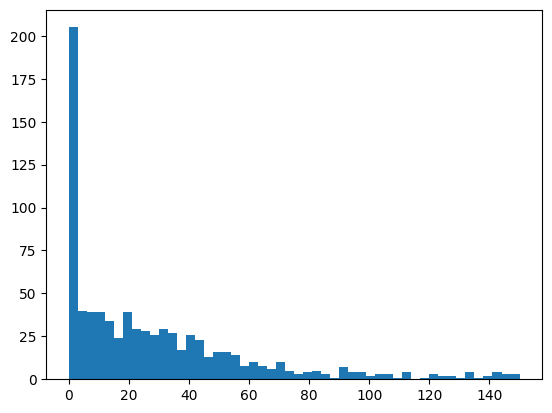

In [36]:
# histogram of sentences len, between 0 and 100
plt.hist([len(doc.metadata["sentences"]) for doc in documents], bins=50, range=(0, 150))

In [33]:
# show doc with most sentences
max_sentences = max(documents, key=lambda d: len(d.metadata["sentences"]))
max_sentences.metadata["url"]
max_sentences.page_content[:1000]

'[Congressional Record (Bound Edition), Volume 155 (2009), Part 5]\n[From the U.S. Government Publishing Office, www.gpo.gov]\nThe Senate met at 9:30 a.m. and was called to order by the Honorable\nTom Udall, a Senator from the State of New Mexico.\nThe Chaplain, Dr. Barry C. Black, offered the following prayer:\nO Lord, our God, by Your will we came into being, and at Your\ncommand, when the right hour is come, we shall one day leave this\nworld. Let Your spirit lead our Senators today. May they increase in\nself-forgetfulness, in simplicity, in courage, and in trust, so that\neach day they will approach nearer to Your likeness. Lord, help them to\noffer themselves afresh to be used in Your service. Show them Your way\nand may they obey Your presence. Give wisdom to the perplexed, fresh\nvigor to the discouraged, and a clearer vision to all who seek Your\nThe Honorable Tom Udall led the Pledge of Allegiance, as follows:\nI pledge allegiance to the Flag of the United States of\nAmerica,

(array([217.,  39.,  23.,  37.,  28.,  25.,  23.,  26.,  27.,  15.,  24.,
         26.,  37.,  18.,  18.,  20.,  18.,  16.,  17.,  15.,  12.,  10.,
          9.,  10.,   5.,   3.,   9.,   3.,   3.,   2.,   2.,   4.,   3.,
          3.,   2.,   3.,   1.,   5.,   2.,   4.,   2.,   3.,   2.,   7.,
          2.,   4.,   1.,   3.,   1.,   1.]),
 array([    0.,   400.,   800.,  1200.,  1600.,  2000.,  2400.,  2800.,
         3200.,  3600.,  4000.,  4400.,  4800.,  5200.,  5600.,  6000.,
         6400.,  6800.,  7200.,  7600.,  8000.,  8400.,  8800.,  9200.,
         9600., 10000., 10400., 10800., 11200., 11600., 12000., 12400.,
        12800., 13200., 13600., 14000., 14400., 14800., 15200., 15600.,
        16000., 16400., 16800., 17200., 17600., 18000., 18400., 18800.,
        19200., 19600., 20000.]),
 <BarContainer object of 50 artists>)

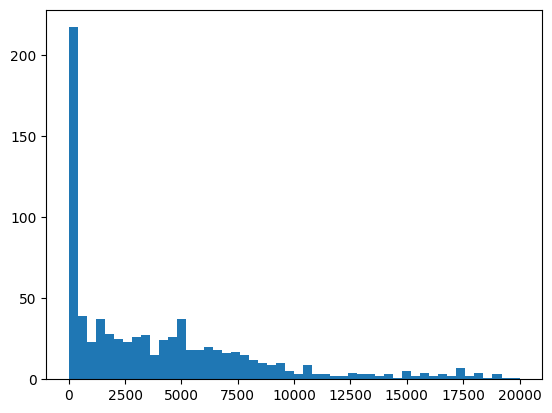

In [38]:
plt.hist([len(doc.page_content) for doc in documents], bins=50, range=(0, 20000))

In [39]:
# trim document page contents to 13000 characters
for doc in documents:
    doc.page_content = doc.page_content[:13000]

## 📐 1. Embedding searches

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [43]:
reranker = KNNRetriever.from_documents(documents, embeddings, k=10)
results = reranker.get_relevant_documents(claim)

display(Markdown("### 🗯️ " + claim))
display(Markdown("*Retrieved by " + embeddings.model_name + "*\n\n"))
# sample 3
for r in results:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n * {r.page_content[:256]}"))